<a href="https://colab.research.google.com/github/jminango20/GoogleModelSearch_NNArchitectureSearch/blob/main/GoogleModelSearch_NeuralNetworkArchitectureSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo de uso de: https://ai.googleblog.com/2021/02/introducing-model-search-open-source.html

In [1]:
!git clone https://github.com/google/model_search.git

Cloning into 'model_search'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 203 (delta 6), reused 22 (delta 4), pack-reused 170
Receiving objects: 100% (203/203), 252.61 KiB | 7.22 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
#Entro al modelo
%cd model_search
!pwd

/content/model_search
/content/model_search


In [3]:
#Listo lo que tiene el directorio
!ls

CONTRIBUTING.md  LICENSE  model_search	README.md  requirements.txt  WORKSPACE


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 516.2MB 29kB/s 
     |████████████████████████████████| 358kB 39.8MB/s 
     |████████████████████████████████| 2.8MB 36.6MB/s 
     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 3.0MB 34.2MB/s 
     |████████████████████████████████| 460kB 30.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=d6ad6d5d123fcc454d41cb857167e8cf5a7ee2518d571b279ede03aa9eb295ff
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=8bc0a83b1a9acb31d3e90518ba2a6584b12d0913ab3074fe3fdb5aa4d64713a4
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-

In [5]:
#Despliego lo instalado
!ls model_search

architecture		hparams		     phoenix_test.py
blocks_builder.py	images		     proto
blocks_builder_test.py	__init__.py	     registry.py
blocks.py		logit_bundler.py     registry_test.py
blocks_test.py		loss_fns.py	     search
BUILD			loss_fns_test.py     single_trainer.py
configs			meta		     single_trainer_test.py
constants.py		metadata	     task_manager.py
controller.py		metric_fns.py	     task_manager_test.py
controller_test.py	metric_fns_test.py   testdata
data			ops		     trainer.bzl
ensembler.py		oss_trainer_lib.py   utils.py
ensembler_test.py	oss_trainer.py	     utils_test.py
generators		oss_trainer_test.py
hparam.py		phoenix.py


In [6]:
#Isntalar proto compiler
!protoc --python_out=./ model_search/proto/phoenix_spec.proto
!protoc --python_out=./ model_search/proto/hparam.proto
!protoc --python_out=./ model_search/proto/distillation_spec.proto
!protoc --python_out=./ model_search/proto/ensembling_spec.proto
!protoc --python_out=./ model_search/proto/transfer_learning_spec.proto

In [7]:
#DataSet con el cual voy a trabajar: Tarjetas de Credito
!wget -O credit_default.xls https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

--2021-03-28 18:27:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/x-httpd-php]
Saving to: ‘credit_default.xls’

credit_default.xls  100%[===================>]   5.28M  9.99MB/s    in 0.5s    

2021-03-28 18:27:29 (9.99 MB/s) - ‘credit_default.xls’ saved [5539328/5539328]



In [9]:
!ls

CONTRIBUTING.md     LICENSE	  README.md	    WORKSPACE
credit_default.xls  model_search  requirements.txt


## Importo las Librerias

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
import model_search
from model_search import constants
from model_search import single_trainer
from model_search.data import csv_data

#### Cargo el DataSet

In [13]:
data = pd.read_excel('credit_default.xls',skiprows=1)

In [14]:
data.head()

ID  LIMIT_BAL  SEX  ...  PAY_AMT5  PAY_AMT6  default payment next month
0   1      20000    2  ...         0         0                           1
1   2     120000    2  ...         0      2000                           1
2   3      90000    2  ...      1000      5000                           0
3   4      50000    2  ...      1069      1000                           0
4   5      50000    1  ...       689       679                           0

[5 rows x 25 columns]

In [15]:
#Renombro
data = data.rename({'default payment next month':'default'},axis=1)

In [16]:
data.head()

ID  LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6  default
0   1      20000    2          2  ...         0         0         0        1
1   2     120000    2          2  ...      1000         0      2000        1
2   3      90000    2          2  ...      1000      1000      5000        0
3   4      50000    2          2  ...      1100      1069      1000        0
4   5      50000    1          2  ...      9000       689       679        0

[5 rows x 25 columns]

#### Visualizacion de los Variables Categoricas

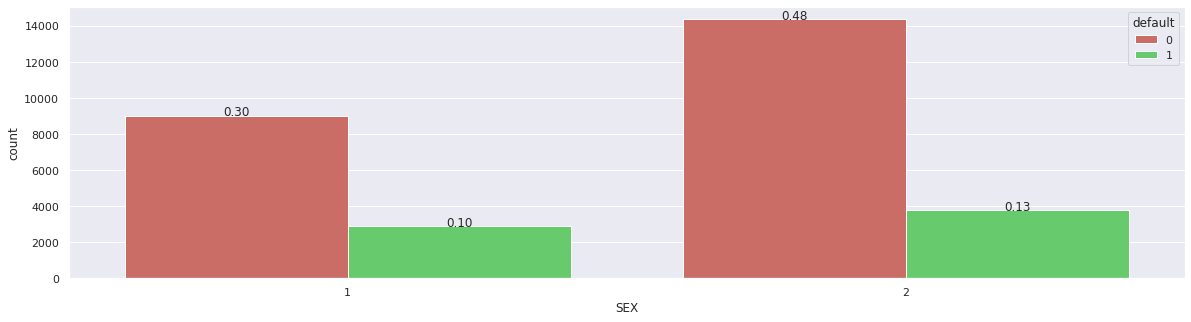

In [18]:
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="SEX", hue="default", data=data)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/data.shape[0]),
            ha="center")

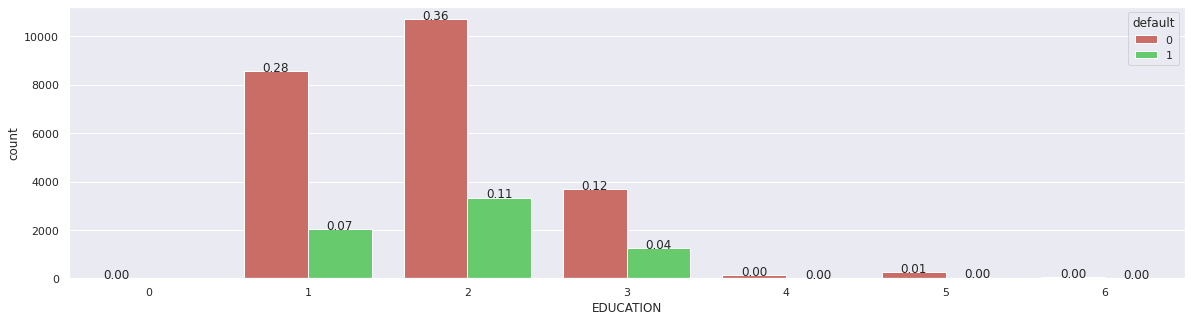

In [20]:
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="EDUCATION", hue="default", data=data)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/data.shape[0]),
            ha="center")

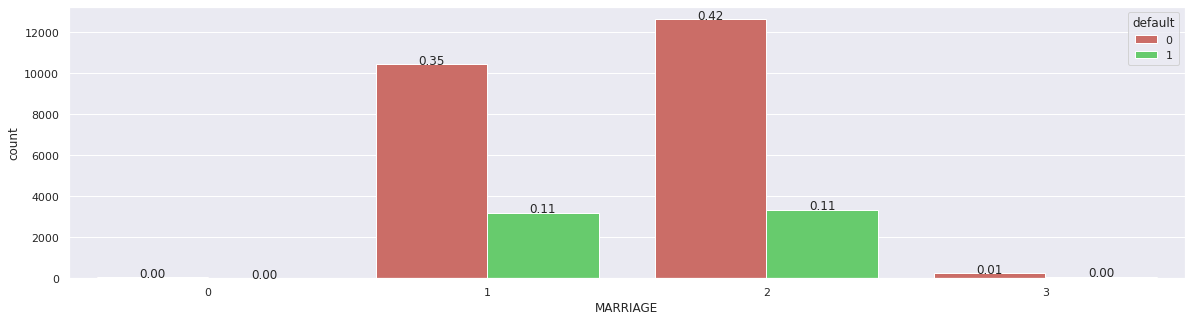

In [21]:
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="MARRIAGE", hue="default", data=data)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/data.shape[0]),
            ha="center")

#### Solo voy a seleccionar los siguientes parametros a modo de ejemplo

In [22]:
categorical=['SEX',	'EDUCATION',	'MARRIAGE']
numeric=['PAY_0',	'PAY_2',	'PAY_3',	'PAY_4',	'PAY_5',	'PAY_6'] #DF final

In [23]:
#### Transformo las Variables categoricas en Numericas

In [24]:
data_final=pd.get_dummies(data=data[categorical], columns=['SEX',	'EDUCATION',	'MARRIAGE'])
data_final

SEX_1  SEX_2  EDUCATION_0  ...  MARRIAGE_1  MARRIAGE_2  MARRIAGE_3
0          0      1            0  ...           1           0           0
1          0      1            0  ...           0           1           0
2          0      1            0  ...           0           1           0
3          0      1            0  ...           1           0           0
4          1      0            0  ...           1           0           0
...      ...    ...          ...  ...         ...         ...         ...
29995      1      0            0  ...           1           0           0
29996      1      0            0  ...           0           1           0
29997      1      0            0  ...           0           1           0
29998      1      0            0  ...           1           0           0
29999      1      0            0  ...           1           0           0

[30000 rows x 13 columns]

#### Concateno las DF

In [25]:
data_default=pd.concat([data['default'], data_final, data[numeric]],  axis=1)
data_default

default  SEX_1  SEX_2  EDUCATION_0  ...  PAY_3  PAY_4  PAY_5  PAY_6
0            1      0      1            0  ...     -1     -1     -2     -2
1            1      0      1            0  ...      0      0      0      2
2            0      0      1            0  ...      0      0      0      0
3            0      0      1            0  ...      0      0      0      0
4            0      1      0            0  ...     -1      0      0      0
...        ...    ...    ...          ...  ...    ...    ...    ...    ...
29995        0      1      0            0  ...      0      0      0      0
29996        0      1      0            0  ...     -1     -1      0      0
29997        1      1      0            0  ...      2     -1      0      0
29998        1      1      0            0  ...      0      0      0     -1
29999        1      1      0            0  ...      0      0      0      0

[30000 rows x 20 columns]

In [26]:
#Target
data_default['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [27]:
#Guardo como .csv por que el modelo no acepta pandas DataFrame
data_default.to_csv('default.csv',sep = ',', index = False, header = None)

### Entrenamiento para lo cual genero una instancia

In [31]:
#label_index-> indica en que columna esta mi target
#logits_dimension -> para problema de clasificacion donde con valor 2 indica que hay dos clases
#record_defaults -> indica el numero de columnas que tiene mi dataset y el valor de 0 debe ser puesto en caso de valores faltantes
#spec -> indica el tipo de red neuronal: dnn: deep neural network
trainer = single_trainer.SingleTrainer(
    data=csv_data.Provider(label_index=0, logits_dimension=2, record_defaults=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], filename="default.csv"),
    spec='model_search/configs/dnn_config.pbtxt')

In [32]:
#Guardo mi resultado en una carpeta
!mkdir /tmp/run_example

In [30]:
#Remueve el directorio
!rm -r /tmp/run_example/

In [34]:
#En Caso de obtener erro en la linea de trainer.try_models rodar este codigo
import sys
from absl import app

# Addresses `UnrecognizedFlagError: Unknown command line flag 'f'`
sys.argv = sys.argv[:1]

# `app.run` calls `sys.exit`
try:
  app.run(lambda argv: None)
except:
  pass

In [35]:
#trainer.try_models -> intenta diference modelos en este caso hemos puesto como default = 5
trainer.try_models(
    number_models=5,
    train_steps=5,
    eval_steps=1,
    root_dir="/tmp/run_example",
    batch_size=512,
    experiment_name="example",
    experiment_owner="model_search_user")

I0328 18:57:48.733172 140463075944320 metadata_store.py:93] MetadataStore with DB connection initialized
I0328 18:57:48.758673 140463075944320 oss_trainer_lib.py:290] creating directory: /tmp/run_example/tuner-1/2
I0328 18:57:48.761629 140463075944320 oss_trainer_lib.py:337] Tuner id: tuner-1
I0328 18:57:48.763882 140463075944320 oss_trainer_lib.py:338] Training with the following hyperparameters: 
I0328 18:57:48.768084 140463075944320 oss_trainer_lib.py:339] {'learning_rate': 3.849713245539738e-06, 'new_block_type': 'FULLY_CONNECTED_RESIDUAL_PROJECT_BATCHNORM', 'optimizer': 'adam', 'initial_architecture_0': 'FULLY_CONNECTED_RESIDUAL_CONCAT', 'exponential_decay_rate': 0.8009505807064935, 'exponential_decay_steps': 2, 'gradient_max_norm': 3, 'dropout_rate': 0.40000001490116116, 'initial_architecture': ['FULLY_CONNECTED_RESIDUAL_CONCAT']}


INFO:tensorflow:TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/2', 'session_master': ''}


I0328 18:57:48.771770 140463075944320 run_config.py:550] TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/2', 'session_master': ''}


INFO:tensorflow:Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/2


I0328 18:57:48.775069 140463075944320 run_config.py:973] Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/2


INFO:tensorflow:Using config: {'_model_dir': '/tmp/run_example/tuner-1/2', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0328 18:57:48.782535 140463075944320 estimator.py:191] Using config: {'_model_dir': '/tmp/run_example/tuner-1/2', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0328 18:57:48.816262 140463075944320 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


W0328 18:57:48.819789 140463075944320 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


I0328 18:57:49.112287 140463075944320 estimator.py:1169] Calling model_fn.
I0328 18:57:49.136384 140463075944320 controller.py:160] trial id: 2
I0328 18:57:49.140970 140463075944320 controller.py:239] intermix ensemble search mode
I0328 18:57:49.162909 140463075944320 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7fbf85176c10>, relevant_trials=[])}
I0328 18:57:49.166278 140463075944320 search_candidate_generator.py:77] Creating new architecture: 
I0328 18:57:49.167917 140463075944320 search_candidate_generator.py:78] [81]


Instructions for updating:
Use keras.layers.dropout instead.


W0328 18:57:49.316963 140463075944320 deprecation.py:323] From /content/model_search/model_search/architecture/architecture_utils.py:473: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Please use `layer.__call__` method instead.


W0328 18:57:49.328249 140463075944320 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/layers/core.py:271: Layer.apply (from tensorflow.python.keras.engine.base_layer_v1) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.


W0328 18:57:49.576290 140463075944320 deprecation.py:323] From /content/model_search/model_search/metric_fns.py:204: auc (from tensorflow.python.ops.metrics_impl) is deprecated and will be removed in a future version.
Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.


INFO:tensorflow:Done calling model_fn.


I0328 18:57:49.849589 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0328 18:57:49.855481 140463075944320 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0328 18:57:50.260187 140463075944320 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0328 18:57:50.376263 140463075944320 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0328 18:57:50.410107 140463075944320 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0328 18:57:50.985412 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/run_example/tuner-1/2/model.ckpt.


I0328 18:57:50.992036 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/run_example/tuner-1/2/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0328 18:57:51.153721 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1...


I0328 19:01:58.861961 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 1...


INFO:tensorflow:Saving checkpoints for 1 into /tmp/run_example/tuner-1/2/model.ckpt.


I0328 19:01:58.867025 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 1 into /tmp/run_example/tuner-1/2/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1...


I0328 19:01:58.975924 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 1...


INFO:tensorflow:loss = 1.0190675, step = 0


I0328 19:01:58.981240 140463075944320 basic_session_run_hooks.py:262] loss = 1.0190675, step = 0


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5...


I0328 19:01:59.107758 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 5...


INFO:tensorflow:Saving checkpoints for 5 into /tmp/run_example/tuner-1/2/model.ckpt.


I0328 19:01:59.112824 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 5 into /tmp/run_example/tuner-1/2/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5...


I0328 19:01:59.217482 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 5...


INFO:tensorflow:Loss for final step: 0.83737856.


I0328 19:02:01.120779 140463075944320 estimator.py:350] Loss for final step: 0.83737856.


INFO:tensorflow:Calling model_fn.


I0328 19:02:01.194950 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:02:01.219686 140463075944320 controller.py:160] trial id: 2
I0328 19:02:01.221966 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:02:01.238172 140463075944320 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7fbf85176c10>, relevant_trials=[])}
I0328 19:02:01.243263 140463075944320 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0328 19:02:01.756461 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-03-28T19:02:01Z


I0328 19:02:01.789822 140463075944320 evaluation.py:255] Starting evaluation at 2021-03-28T19:02:01Z


INFO:tensorflow:Graph was finalized.


I0328 19:02:01.884631 140463075944320 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/2/model.ckpt-5


I0328 19:02:01.897794 140463075944320 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/2/model.ckpt-5


INFO:tensorflow:Running local_init_op.


I0328 19:02:02.001936 140463075944320 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0328 19:02:02.048128 140463075944320 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


I0328 19:02:02.308678 140463075944320 evaluation.py:167] Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.58917s


I0328 19:02:02.383058 140463075944320 evaluation.py:273] Inference Time : 0.58917s


INFO:tensorflow:Finished evaluation at 2021-03-28-19:02:02


I0328 19:02:02.386074 140463075944320 evaluation.py:276] Finished evaluation at 2021-03-28-19:02:02


INFO:tensorflow:Saving dict for global step 5: accuracy = 0.45117188, auc_pr = 0.23254794, auc_roc = 0.49173853, global_step = 5, loss = 0.8933107, num_parameters = 458


I0328 19:02:02.395576 140463075944320 estimator.py:2066] Saving dict for global step 5: accuracy = 0.45117188, auc_pr = 0.23254794, auc_roc = 0.49173853, global_step = 5, loss = 0.8933107, num_parameters = 458


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/2/model.ckpt-5


I0328 19:02:02.610349 140463075944320 estimator.py:2127] Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/2/model.ckpt-5
I0328 19:02:02.615729 140463075944320 phoenix.py:123] Saving the following evaluation dictionary.
I0328 19:02:02.618004 140463075944320 phoenix.py:124] {'accuracy': 0.451171875, 'auc_pr': 0.23254793882369995, 'auc_roc': 0.49173852801322937, 'loss': 0.8933107256889343, 'num_parameters': 458, 'global_step': 5}
I0328 19:02:02.620136 140463075944320 ml_metadata_db.py:161] Storing the following evaluation dictionary,
I0328 19:02:02.622219 140463075944320 ml_metadata_db.py:162] {'accuracy': 0.451171875, 'auc_pr': 0.23254793882369995, 'auc_roc': 0.49173852801322937, 'loss': 0.8933107256889343, 'num_parameters': 458, 'global_step': 5}
I0328 19:02:02.623472 140463075944320 ml_metadata_db.py:163] For the model in the following model dictionary,
I0328 19:02:02.624759 140463075944320 ml_metadata_db.py:164] /tmp/run_example/tuner-1/2


INFO:tensorflow:Calling model_fn.


I0328 19:02:02.689032 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:02:02.714750 140463075944320 controller.py:160] trial id: 2
I0328 19:02:02.717806 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:02:02.735252 140463075944320 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7fbf85176c10>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf8709ca50>])}
I0328 19:02:02.740502 140463075944320 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0328 19:02:02.949300 140463075944320 estimator.py:1171] Done calling model_fn.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W0328 19:02:02.957219 140463075944320 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0328 19:02:02.971261 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0328 19:02:02.983705 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0328 19:02:02.992569 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0328 19:02:02.996257 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0328 19:02:02.998823 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/2/model.ckpt-5


I0328 19:02:03.061502 140463075944320 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/2/model.ckpt-5


INFO:tensorflow:Assets added to graph.


I0328 19:02:03.096457 140463075944320 builder_impl.py:666] Assets added to graph.


INFO:tensorflow:No assets to write.


I0328 19:02:03.104043 140463075944320 builder_impl.py:461] No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/run_example/tuner-1/2/saved_model/temp-1616958122/saved_model.pb


I0328 19:02:03.181994 140463075944320 builder_impl.py:426] SavedModel written to: /tmp/run_example/tuner-1/2/saved_model/temp-1616958122/saved_model.pb
I0328 19:02:03.196549 140463075944320 oss_trainer_lib.py:265] Evaluation results: {'accuracy': 0.45117188, 'auc_pr': 0.23254794, 'auc_roc': 0.49173853, 'loss': 0.8933107, 'num_parameters': 458, 'global_step': 5}
I0328 19:02:03.208012 140463075944320 oss_trainer_lib.py:290] creating directory: /tmp/run_example/tuner-1/3
I0328 19:02:03.209456 140463075944320 oss_trainer_lib.py:337] Tuner id: tuner-1
I0328 19:02:03.216445 140463075944320 oss_trainer_lib.py:338] Training with the following hyperparameters: 
I0328 19:02:03.217602 140463075944320 oss_trainer_lib.py:339] {'learning_rate': 9.548223581929367e-06, 'new_block_type': 'FIXED_OUTPUT_FULLY_CONNECTED_128', 'optimizer': 'adam', 'initial_architecture_0': 'FIXED_OUTPUT_FULLY_CONNECTED_1024', 'exponential_decay_rate': 0.7743534893023669, 'exponential_decay_steps': 1, 'gradient_max_norm': 4

INFO:tensorflow:TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/3', 'session_master': ''}


I0328 19:02:03.224473 140463075944320 run_config.py:550] TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/3', 'session_master': ''}


INFO:tensorflow:Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/3


I0328 19:02:03.230662 140463075944320 run_config.py:973] Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/3


INFO:tensorflow:Using config: {'_model_dir': '/tmp/run_example/tuner-1/3', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0328 19:02:03.238341 140463075944320 estimator.py:191] Using config: {'_model_dir': '/tmp/run_example/tuner-1/3', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0328 19:02:03.329833 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:02:03.356735 140463075944320 controller.py:160] trial id: 3
I0328 19:02:03.358812 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:02:03.374282 140463075944320 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7fbf85176c10>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf8708ca90>])}
I0328 19:02:03.381805 140463075944320 coordinate_descent.py:58] Maximal depth allowed: 1
I0328 19:02:03.384083 140463075944320 coordinate_descent.py:70] using evolution
I0328 19:02:03.386162 140463075944320 search_candidate_generator.py:77] Creating new architecture: 
I0328 19:02:03.388095 140463075944320 search_candidate_generator.py:78] [22]


INFO:tensorflow:Done calling model_fn.


I0328 19:02:04.028264 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0328 19:02:04.034241 140463075944320 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0328 19:02:04.269746 140463075944320 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0328 19:02:04.364675 140463075944320 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0328 19:02:04.403262 140463075944320 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0328 19:02:04.958923 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/run_example/tuner-1/3/model.ckpt.


I0328 19:02:04.967213 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/run_example/tuner-1/3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0328 19:02:05.093302 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1...


I0328 19:06:25.427345 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 1...


INFO:tensorflow:Saving checkpoints for 1 into /tmp/run_example/tuner-1/3/model.ckpt.


I0328 19:06:25.433288 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 1 into /tmp/run_example/tuner-1/3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1...


I0328 19:06:25.571274 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 1...


INFO:tensorflow:loss = 0.82322943, step = 0


I0328 19:06:25.581795 140463075944320 basic_session_run_hooks.py:262] loss = 0.82322943, step = 0


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5...


I0328 19:06:25.753575 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 5...


INFO:tensorflow:Saving checkpoints for 5 into /tmp/run_example/tuner-1/3/model.ckpt.


I0328 19:06:25.758759 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 5 into /tmp/run_example/tuner-1/3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5...


I0328 19:06:25.918798 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 5...


INFO:tensorflow:Loss for final step: 0.8992113.


I0328 19:06:27.038355 140463075944320 estimator.py:350] Loss for final step: 0.8992113.


INFO:tensorflow:Calling model_fn.


I0328 19:06:27.105443 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:06:27.129097 140463075944320 controller.py:160] trial id: 3
I0328 19:06:27.131630 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:06:27.149486 140463075944320 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7fbf85176c10>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf86dd4e10>])}
I0328 19:06:27.159148 140463075944320 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0328 19:06:27.649672 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-03-28T19:06:27Z


I0328 19:06:27.682944 140463075944320 evaluation.py:255] Starting evaluation at 2021-03-28T19:06:27Z


INFO:tensorflow:Graph was finalized.


I0328 19:06:27.761401 140463075944320 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/3/model.ckpt-5


I0328 19:06:27.770466 140463075944320 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/3/model.ckpt-5


INFO:tensorflow:Running local_init_op.


I0328 19:06:27.851726 140463075944320 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0328 19:06:27.887277 140463075944320 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


I0328 19:06:28.112740 140463075944320 evaluation.py:167] Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.48248s


I0328 19:06:28.169349 140463075944320 evaluation.py:273] Inference Time : 0.48248s


INFO:tensorflow:Finished evaluation at 2021-03-28-19:06:28


I0328 19:06:28.172175 140463075944320 evaluation.py:276] Finished evaluation at 2021-03-28-19:06:28


INFO:tensorflow:Saving dict for global step 5: accuracy = 0.25976562, auc_pr = 0.27957395, auc_roc = 0.54642326, global_step = 5, loss = 0.8762008, num_parameters = 2818


I0328 19:06:28.176143 140463075944320 estimator.py:2066] Saving dict for global step 5: accuracy = 0.25976562, auc_pr = 0.27957395, auc_roc = 0.54642326, global_step = 5, loss = 0.8762008, num_parameters = 2818


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/3/model.ckpt-5


I0328 19:06:28.347892 140463075944320 estimator.py:2127] Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/3/model.ckpt-5
I0328 19:06:28.357915 140463075944320 phoenix.py:123] Saving the following evaluation dictionary.
I0328 19:06:28.360723 140463075944320 phoenix.py:124] {'accuracy': 0.259765625, 'auc_pr': 0.2795739471912384, 'auc_roc': 0.5464232563972473, 'loss': 0.876200795173645, 'num_parameters': 2818, 'global_step': 5}
I0328 19:06:28.364107 140463075944320 ml_metadata_db.py:161] Storing the following evaluation dictionary,
I0328 19:06:28.369072 140463075944320 ml_metadata_db.py:162] {'accuracy': 0.259765625, 'auc_pr': 0.2795739471912384, 'auc_roc': 0.5464232563972473, 'loss': 0.876200795173645, 'num_parameters': 2818, 'global_step': 5}
I0328 19:06:28.372548 140463075944320 ml_metadata_db.py:163] For the model in the following model dictionary,
I0328 19:06:28.377293 140463075944320 ml_metadata_db.py:164] /tmp/run_example/tuner-1/3


INFO:tensorflow:Calling model_fn.


I0328 19:06:28.434018 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:06:28.464421 140463075944320 controller.py:160] trial id: 3
I0328 19:06:28.466673 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:06:28.484549 140463075944320 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7fbf85176c10>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf86e83990>, <model_search.metadata.trial.Trial object at 0x7fbf86e83490>])}
I0328 19:06:28.490908 140463075944320 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0328 19:06:28.681361 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0328 19:06:28.693296 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0328 19:06:28.700544 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0328 19:06:28.714321 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0328 19:06:28.718633 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0328 19:06:28.735885 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/3/model.ckpt-5


I0328 19:06:28.779428 140463075944320 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/3/model.ckpt-5


INFO:tensorflow:Assets added to graph.


I0328 19:06:28.806868 140463075944320 builder_impl.py:666] Assets added to graph.


INFO:tensorflow:No assets to write.


I0328 19:06:28.809970 140463075944320 builder_impl.py:461] No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/run_example/tuner-1/3/saved_model/temp-1616958388/saved_model.pb


I0328 19:06:28.887076 140463075944320 builder_impl.py:426] SavedModel written to: /tmp/run_example/tuner-1/3/saved_model/temp-1616958388/saved_model.pb
I0328 19:06:28.899368 140463075944320 oss_trainer_lib.py:265] Evaluation results: {'accuracy': 0.25976562, 'auc_pr': 0.27957395, 'auc_roc': 0.54642326, 'loss': 0.8762008, 'num_parameters': 2818, 'global_step': 5}
I0328 19:06:28.909316 140463075944320 oss_trainer_lib.py:290] creating directory: /tmp/run_example/tuner-1/4
I0328 19:06:28.912392 140463075944320 oss_trainer_lib.py:337] Tuner id: tuner-1
I0328 19:06:28.914697 140463075944320 oss_trainer_lib.py:338] Training with the following hyperparameters: 
I0328 19:06:28.916800 140463075944320 oss_trainer_lib.py:339] {'learning_rate': 5.546579328700753e-06, 'new_block_type': 'FIXED_OUTPUT_FULLY_CONNECTED_512', 'optimizer': 'adagrad', 'initial_architecture_0': 'FIXED_OUTPUT_FULLY_CONNECTED_1024', 'exponential_decay_rate': 0.8221897391646549, 'exponential_decay_steps': 5, 'gradient_max_norm

INFO:tensorflow:TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/4', 'session_master': ''}


I0328 19:06:28.919255 140463075944320 run_config.py:550] TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/4', 'session_master': ''}


INFO:tensorflow:Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/4


I0328 19:06:28.923081 140463075944320 run_config.py:973] Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/4


INFO:tensorflow:Using config: {'_model_dir': '/tmp/run_example/tuner-1/4', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0328 19:06:28.925910 140463075944320 estimator.py:191] Using config: {'_model_dir': '/tmp/run_example/tuner-1/4', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0328 19:06:29.037755 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:06:29.061362 140463075944320 controller.py:160] trial id: 4
I0328 19:06:29.063337 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:06:29.079759 140463075944320 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7fbf85176c10>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf86dc4810>, <model_search.metadata.trial.Trial object at 0x7fbf86e01f50>])}
I0328 19:06:29.089757 140463075944320 coordinate_descent.py:58] Maximal depth allowed: 1
I0328 19:06:29.091911 140463075944320 coordinate_descent.py:70] using evolution
I0328 19:06:29.096977 140463075944320 search_candidate_generator.py:77] Creating new architecture: 
I0328 19:06:29.101444 140463075944320 search_candidate_generator.py:78] [24]


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0328 19:06:29.404799 140463075944320 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/training/adagrad.py:77: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


I0328 19:06:29.719196 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0328 19:06:29.725948 140463075944320 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0328 19:06:30.023747 140463075944320 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0328 19:06:30.157109 140463075944320 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0328 19:06:30.202721 140463075944320 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0328 19:06:30.804752 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/run_example/tuner-1/4/model.ckpt.


I0328 19:06:30.809480 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/run_example/tuner-1/4/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0328 19:06:30.949081 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1...


I0328 19:10:49.459303 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 1...


INFO:tensorflow:Saving checkpoints for 1 into /tmp/run_example/tuner-1/4/model.ckpt.


I0328 19:10:49.470541 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 1 into /tmp/run_example/tuner-1/4/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1...


I0328 19:10:49.612106 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 1...


INFO:tensorflow:loss = 0.7662597, step = 0


I0328 19:10:49.624240 140463075944320 basic_session_run_hooks.py:262] loss = 0.7662597, step = 0


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5...


I0328 19:10:49.792781 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 5...


INFO:tensorflow:Saving checkpoints for 5 into /tmp/run_example/tuner-1/4/model.ckpt.


I0328 19:10:49.795946 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 5 into /tmp/run_example/tuner-1/4/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5...


I0328 19:10:49.919769 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 5...


INFO:tensorflow:Loss for final step: 0.75578153.


I0328 19:10:50.909194 140463075944320 estimator.py:350] Loss for final step: 0.75578153.


INFO:tensorflow:Calling model_fn.


I0328 19:10:50.995307 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:10:51.023674 140463075944320 controller.py:160] trial id: 4
I0328 19:10:51.026291 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:10:51.051768 140463075944320 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7fbf85176c10>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf868a2cd0>, <model_search.metadata.trial.Trial object at 0x7fbf86898b10>])}
I0328 19:10:51.055726 140463075944320 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0328 19:10:51.558367 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-03-28T19:10:51Z


I0328 19:10:51.596429 140463075944320 evaluation.py:255] Starting evaluation at 2021-03-28T19:10:51Z


INFO:tensorflow:Graph was finalized.


I0328 19:10:51.689371 140463075944320 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/4/model.ckpt-5


I0328 19:10:51.697550 140463075944320 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/4/model.ckpt-5


INFO:tensorflow:Running local_init_op.


I0328 19:10:51.826957 140463075944320 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0328 19:10:51.875713 140463075944320 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


I0328 19:10:52.179085 140463075944320 evaluation.py:167] Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.65805s


I0328 19:10:52.257603 140463075944320 evaluation.py:273] Inference Time : 0.65805s


INFO:tensorflow:Finished evaluation at 2021-03-28-19:10:52


I0328 19:10:52.260490 140463075944320 evaluation.py:276] Finished evaluation at 2021-03-28-19:10:52


INFO:tensorflow:Saving dict for global step 5: accuracy = 0.29492188, auc_pr = 0.18908152, auc_roc = 0.41346654, global_step = 5, loss = 0.7562523, num_parameters = 11266


I0328 19:10:52.270141 140463075944320 estimator.py:2066] Saving dict for global step 5: accuracy = 0.29492188, auc_pr = 0.18908152, auc_roc = 0.41346654, global_step = 5, loss = 0.7562523, num_parameters = 11266


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/4/model.ckpt-5


I0328 19:10:52.875487 140463075944320 estimator.py:2127] Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/4/model.ckpt-5
I0328 19:10:52.881883 140463075944320 phoenix.py:123] Saving the following evaluation dictionary.
I0328 19:10:52.884152 140463075944320 phoenix.py:124] {'accuracy': 0.294921875, 'auc_pr': 0.18908151984214783, 'auc_roc': 0.41346654295921326, 'loss': 0.7562522888183594, 'num_parameters': 11266, 'global_step': 5}
I0328 19:10:52.886816 140463075944320 ml_metadata_db.py:161] Storing the following evaluation dictionary,
I0328 19:10:52.888902 140463075944320 ml_metadata_db.py:162] {'accuracy': 0.294921875, 'auc_pr': 0.18908151984214783, 'auc_roc': 0.41346654295921326, 'loss': 0.7562522888183594, 'num_parameters': 11266, 'global_step': 5}
I0328 19:10:52.890223 140463075944320 ml_metadata_db.py:163] For the model in the following model dictionary,
I0328 19:10:52.891530 140463075944320 ml_metadata_db.py:164] /tmp/run_example/tuner-1/4


INFO:tensorflow:Calling model_fn.


I0328 19:10:52.960819 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:10:52.990800 140463075944320 controller.py:160] trial id: 4
I0328 19:10:52.993325 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:10:53.013330 140463075944320 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7fbf85176c10>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf86e73f50>, <model_search.metadata.trial.Trial object at 0x7fbf86e73450>, <model_search.metadata.trial.Trial object at 0x7fbf86e73110>])}
I0328 19:10:53.024857 140463075944320 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0328 19:10:53.238903 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0328 19:10:53.249393 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0328 19:10:53.266224 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0328 19:10:53.269741 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0328 19:10:53.280932 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0328 19:10:53.286608 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/4/model.ckpt-5


I0328 19:10:53.338219 140463075944320 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/4/model.ckpt-5


INFO:tensorflow:Assets added to graph.


I0328 19:10:53.374744 140463075944320 builder_impl.py:666] Assets added to graph.


INFO:tensorflow:No assets to write.


I0328 19:10:53.382253 140463075944320 builder_impl.py:461] No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/run_example/tuner-1/4/saved_model/temp-1616958652/saved_model.pb


I0328 19:10:53.474989 140463075944320 builder_impl.py:426] SavedModel written to: /tmp/run_example/tuner-1/4/saved_model/temp-1616958652/saved_model.pb
I0328 19:10:53.495959 140463075944320 oss_trainer_lib.py:265] Evaluation results: {'accuracy': 0.29492188, 'auc_pr': 0.18908152, 'auc_roc': 0.41346654, 'loss': 0.7562523, 'num_parameters': 11266, 'global_step': 5}
I0328 19:10:53.505287 140463075944320 oss_trainer_lib.py:290] creating directory: /tmp/run_example/tuner-1/5
I0328 19:10:53.508869 140463075944320 oss_trainer_lib.py:337] Tuner id: tuner-1
I0328 19:10:53.514693 140463075944320 oss_trainer_lib.py:338] Training with the following hyperparameters: 
I0328 19:10:53.522139 140463075944320 oss_trainer_lib.py:339] {'learning_rate': 3.784740984641629e-06, 'new_block_type': 'FULLY_CONNECTED_RESIDUAL_PROJECT_BATCHNORM', 'optimizer': 'rmsprop', 'initial_architecture_0': 'FULLY_CONNECTED_RESIDUAL_PROJECT_BATCHNORM', 'exponential_decay_rate': 0.8112279495686324, 'exponential_decay_steps': 5

INFO:tensorflow:TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/5', 'session_master': ''}


I0328 19:10:53.531464 140463075944320 run_config.py:550] TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/5', 'session_master': ''}


INFO:tensorflow:Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/5


I0328 19:10:53.535962 140463075944320 run_config.py:973] Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/5


INFO:tensorflow:Using config: {'_model_dir': '/tmp/run_example/tuner-1/5', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0328 19:10:53.548750 140463075944320 estimator.py:191] Using config: {'_model_dir': '/tmp/run_example/tuner-1/5', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0328 19:10:53.651448 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:10:53.674036 140463075944320 controller.py:160] trial id: 5
I0328 19:10:53.676602 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:10:53.699240 140463075944320 phoenix.py:371] {'prior_generator': GeneratorWithTrials(instance=<model_search.generators.prior_generator.PriorGenerator object at 0x7fbf85176e50>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf882be290>, <model_search.metadata.trial.Trial object at 0x7fbf8829ca50>, <model_search.metadata.trial.Trial object at 0x7fbfe0b5ffd0>])}
I0328 19:10:53.912146 140463075944320 architecture_utils.py:382] warm starting the following tensors
I0328 19:10:53.913778 140463075944320 architecture_utils.py:383] {'Phoenix/search_generator_0/1_FULLY_CONNECTED_RESIDUAL_CONCAT_81/dense/kernel': <tf.Variable 'Phoenix/prior_generator_0/1_FULLY_CONNECTED_RESIDUAL_CONCAT_81/dense/kernel:0' shape=(19, 19) dtype=float32>, 'Phoeni

INFO:tensorflow:Done calling model_fn.


I0328 19:10:54.718657 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0328 19:10:54.726477 140463075944320 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0328 19:10:55.128291 140463075944320 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0328 19:10:55.308837 140463075944320 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0328 19:10:55.367090 140463075944320 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0328 19:10:56.179633 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/run_example/tuner-1/5/model.ckpt.


I0328 19:10:56.184373 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/run_example/tuner-1/5/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0328 19:10:56.375320 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 101...


I0328 19:15:24.044934 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 101...


INFO:tensorflow:Saving checkpoints for 101 into /tmp/run_example/tuner-1/5/model.ckpt.


I0328 19:15:24.049693 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 101 into /tmp/run_example/tuner-1/5/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 101...


I0328 19:15:24.247925 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 101...


INFO:tensorflow:loss = 0.8273457, step = 0


I0328 19:15:24.259990 140463075944320 basic_session_run_hooks.py:262] loss = 0.8273457, step = 0


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 202...


I0328 19:15:24.463457 140463075944320 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 202...


INFO:tensorflow:Saving checkpoints for 202 into /tmp/run_example/tuner-1/5/model.ckpt.


I0328 19:15:24.470015 140463075944320 basic_session_run_hooks.py:618] Saving checkpoints for 202 into /tmp/run_example/tuner-1/5/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 202...


I0328 19:15:24.666909 140463075944320 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 202...


INFO:tensorflow:Loss for final step: 0.8044014.


I0328 19:15:25.674082 140463075944320 estimator.py:350] Loss for final step: 0.8044014.


INFO:tensorflow:Calling model_fn.


I0328 19:15:25.739662 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:15:25.768105 140463075944320 controller.py:160] trial id: 5
I0328 19:15:25.770007 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:15:25.785474 140463075944320 phoenix.py:371] {'prior_generator': GeneratorWithTrials(instance=<model_search.generators.prior_generator.PriorGenerator object at 0x7fbf85176e50>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf86e541d0>, <model_search.metadata.trial.Trial object at 0x7fbf86e47590>, <model_search.metadata.trial.Trial object at 0x7fbf86e57810>])}
I0328 19:15:25.790724 140463075944320 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0328 19:15:26.585899 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-03-28T19:15:26Z


I0328 19:15:26.618676 140463075944320 evaluation.py:255] Starting evaluation at 2021-03-28T19:15:26Z


INFO:tensorflow:Graph was finalized.


I0328 19:15:26.714830 140463075944320 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/5/model.ckpt-202


I0328 19:15:26.725726 140463075944320 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/5/model.ckpt-202


INFO:tensorflow:Running local_init_op.


I0328 19:15:26.859346 140463075944320 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0328 19:15:26.905835 140463075944320 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


I0328 19:15:27.214030 140463075944320 evaluation.py:167] Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.66623s


I0328 19:15:27.288842 140463075944320 evaluation.py:273] Inference Time : 0.66623s


INFO:tensorflow:Finished evaluation at 2021-03-28-19:15:27


I0328 19:15:27.295412 140463075944320 evaluation.py:276] Finished evaluation at 2021-03-28-19:15:27


INFO:tensorflow:Saving dict for global step 202: accuracy = 0.31054688, auc_pr = 0.23175757, auc_roc = 0.49140108, global_step = 202, loss = 0.8140644, num_parameters = 14542


I0328 19:15:27.299874 140463075944320 estimator.py:2066] Saving dict for global step 202: accuracy = 0.31054688, auc_pr = 0.23175757, auc_roc = 0.49140108, global_step = 202, loss = 0.8140644, num_parameters = 14542


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 202: /tmp/run_example/tuner-1/5/model.ckpt-202


I0328 19:15:27.557104 140463075944320 estimator.py:2127] Saving 'checkpoint_path' summary for global step 202: /tmp/run_example/tuner-1/5/model.ckpt-202
I0328 19:15:27.561617 140463075944320 phoenix.py:123] Saving the following evaluation dictionary.
I0328 19:15:27.564338 140463075944320 phoenix.py:124] {'accuracy': 0.310546875, 'auc_pr': 0.23175756633281708, 'auc_roc': 0.4914010763168335, 'loss': 0.8140643835067749, 'num_parameters': 14542, 'global_step': 202}
I0328 19:15:27.566729 140463075944320 ml_metadata_db.py:161] Storing the following evaluation dictionary,
I0328 19:15:27.568868 140463075944320 ml_metadata_db.py:162] {'accuracy': 0.310546875, 'auc_pr': 0.23175756633281708, 'auc_roc': 0.4914010763168335, 'loss': 0.8140643835067749, 'num_parameters': 14542, 'global_step': 202}
I0328 19:15:27.570327 140463075944320 ml_metadata_db.py:163] For the model in the following model dictionary,
I0328 19:15:27.571913 140463075944320 ml_metadata_db.py:164] /tmp/run_example/tuner-1/5


INFO:tensorflow:Calling model_fn.


I0328 19:15:27.623796 140463075944320 estimator.py:1169] Calling model_fn.
I0328 19:15:27.651692 140463075944320 controller.py:160] trial id: 5
I0328 19:15:27.655751 140463075944320 controller.py:239] intermix ensemble search mode
I0328 19:15:27.669712 140463075944320 phoenix.py:371] {'prior_generator': GeneratorWithTrials(instance=<model_search.generators.prior_generator.PriorGenerator object at 0x7fbf85176e50>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7fbf87199510>, <model_search.metadata.trial.Trial object at 0x7fbf87199a10>, <model_search.metadata.trial.Trial object at 0x7fbf86c40210>])}
I0328 19:15:27.679373 140463075944320 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0328 19:15:28.172418 140463075944320 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0328 19:15:28.182716 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0328 19:15:28.198325 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0328 19:15:28.211676 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0328 19:15:28.214568 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0328 19:15:28.216944 140463075944320 export_utils.py:170] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/5/model.ckpt-202


I0328 19:15:28.289540 140463075944320 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/5/model.ckpt-202


INFO:tensorflow:Assets added to graph.


I0328 19:15:28.339162 140463075944320 builder_impl.py:666] Assets added to graph.


INFO:tensorflow:No assets to write.


I0328 19:15:28.343683 140463075944320 builder_impl.py:461] No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/run_example/tuner-1/5/saved_model/temp-1616958927/saved_model.pb


I0328 19:15:28.488667 140463075944320 builder_impl.py:426] SavedModel written to: /tmp/run_example/tuner-1/5/saved_model/temp-1616958927/saved_model.pb
I0328 19:15:28.502294 140463075944320 oss_trainer_lib.py:265] Evaluation results: {'accuracy': 0.31054688, 'auc_pr': 0.23175757, 'auc_roc': 0.49140108, 'loss': 0.8140644, 'num_parameters': 14542, 'global_step': 202}
I0328 19:15:28.516543 140463075944320 oss_trainer_lib.py:290] creating directory: /tmp/run_example/tuner-1/6


In [36]:
!ls /tmp/run_example/tuner-1/3

3.arch.txt				     model.ckpt-1.data-00000-of-00001
3.search_edge.txt			     model.ckpt-1.index
checkpoint				     model.ckpt-1.meta
eval					     model.ckpt-5.data-00000-of-00001
events.out.tfevents.1616958124.5d667592a1f7  model.ckpt-5.index
graph.pbtxt				     model.ckpt-5.meta
model.ckpt-0.data-00000-of-00001	     replay_config.pbtxt
model.ckpt-0.index			     saved_model
model.ckpt-0.meta			     search_generator_0


In [37]:
#Observar la arquitectura
!cat /tmp/run_example/tuner-1/2/graph.pbtxt

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "_output_shapes"
    value {
      list {
        shape {
        }
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "_output_shapes"
    value {
      list {
        shape {
        }
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "globa